In [1]:
import gdal, osr
import collections
import gc
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import collections
from collections import OrderedDict
import hdmedians as hd
import geopandas as gpd
from osgeo import ogr
import datacube
import hdmedians as hd

from utils.data_cube_utilities.dc_utilities import create_default_clean_mask
from utils.data_cube_utilities.dc_display_map import display_map

from Scripts.DEAPlotting import rgb


from odc.ui import with_ui_cbk

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

dc = datacube.Datacube(app = 'bavaria_one', config = '/home/datacube/.datacube.conf')

In [2]:
from s2fn import unpack_s2bits, s2_unpack_scl
from utils.data_cube_utilities.cloud_coverage import s2_clean_mask, s2_cct

In [3]:
# load BWI tract 15613
aoi01 = gpd.read_file('Data/BDC/trnr_15613.shp')
aoi = aoi01.to_crs('EPSG:25832')
aoi_wgs = aoi.to_crs('EPSG:4326')


x_min = aoi.bounds.iloc[0,0]
x_max = aoi.bounds.iloc[0,2]
y_min = aoi.bounds.iloc[0,1]
y_max = aoi.bounds.iloc[0,3]


longitude_extents = (aoi_wgs.bounds.iloc[0,0],aoi_wgs.bounds.iloc[0,2])
latitude_extents  = (aoi_wgs.bounds.iloc[0,1],aoi_wgs.bounds.iloc[0,3])
display_map(latitude = latitude_extents, longitude = longitude_extents)

In [4]:
dataset = dc.load(product = 's2_l2a_bavaria', 
                  x=(x_min, x_max),
                  y=(y_min, y_max),
                  crs='EPSG:25832',
                  time=('2018-01-01', '2018-12-31'),
                  progress_cbk=with_ui_cbk())

In [5]:
# delete no data values
mean = dataset.mean(dim=['y','x'])
ls = mean.time.where(mean.red != 0, drop=True)
dataset_null = dataset.sel(time=pd.to_datetime(ls.values.tolist()))

if len(dataset.time) == len(dataset_null.time):
    print('No reduced data')
    del(dataset_null, mean, ls)
else:
    print('Datasets are reduced from', len(dataset.time), 'to', len(dataset_null.time))
    del(mean, ls)

#dataset = dataset_null

Datasets are reduced from 143 to 141


In [6]:
aoi.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - 6°E to 12°E and ETRS89 by country
- bounds: (6.0, 38.76, 12.0, 83.92)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
aoi01.crs

<Projected CRS: EPSG:31467>
Name: DHDN / 3-degree Gauss-Kruger zone 3
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Germany - West-Germany - 7.5°E to 10.5°E
- bounds: (7.5, 47.27, 10.51, 55.09)
Coordinate Operation:
- name: 3-degree Gauss-Kruger zone 3
- method: Transverse Mercator
Datum: Deutsches Hauptdreiecksnetz
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

## The xarray

#### What is xarray?
- xarray is an open source project and Python package
- designed to perform labelled data analysis on multi-dimensional arrays
- xarray.Dataset is an in-memory representation of a netCDF file.
- xarray is built on top of the dataprocessing library Pandas 

Xarray has two data structures:
- DataArray — for a single data variable
- Dataset — a container for multiple DataArrays (data variables)

`xarray.DataArray` has the following key properties:

`values` : a numpy.ndarray holding the array’s values

`dims` : dimension names for each axis (e.g. 'lat', 'lon', 'time')

`coords` : a dict-like container of arrays (coordinates) that label each point 

`attrs`: an OrderedDict to hold arbitrary metadata 


In [11]:
type(dataset)

xarray.core.dataset.Dataset

In [12]:
dataset

<xarray.Dataset>
Dimensions:          (time: 143, x: 227, y: 227)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-31...
  * y                (y) float64 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x                (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) int16 9680 9680 9680 9250 ... 9087 8356 8356
    blue             (time, y, x) int16 9280 9080 8960 8880 ... 7684 7596 7524
    green            (time, y, x) int16 8736 8632 8504 8400 ... 6988 6860 6688
    red              (time, y, x) int16 8688 8704 8768 8808 ... 6668 6624 6468
    red_edge1        (time, y, x) int16 9029 9029 9029 9204 ... 7117 6637 6637
    red_edge2        (time, y, x) int16 8820 8935 8935 9137 ... 6836 6410 6410
    red_edge3        (time, y, x) int16 8837 8818 8818 8971 ... 6649 6260 6260
    nir              (time, y, x) int16 9088 9032 8920 8832 ... 6292 6148 6012
    narrow_nir       (time, y, x) int16 8845 8941 8941 8891 ... 6601 6201 6201
    water_vapour     (time, y, x) int16 8787 8787 8787 8141 ... 7644 6492 6492
    swir1            (time, y, x) int16 4750 4808 4808 4925 ... 3880 3577 3577
    swir2            (time, y, x) int16 4018 4196 4196 4201 ... 2605 2278 2278
    scl              (time, y, x) uint8 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

#### Select single xarray.DataArray

In [13]:
dataset.time

<xarray.DataArray 'time' (time: 143)>
array(['2018-01-02T10:24:20.000000000', '2018-01-05T10:34:19.000000000',
       '2018-01-07T10:24:01.000000000', '2018-01-10T10:34:07.000000000',
       '2018-01-12T10:26:30.000000000', '2018-01-15T10:34:54.000000000',
       '2018-01-17T10:23:41.000000000', '2018-01-20T10:33:35.000000000',
       '2018-01-22T10:23:23.000000000', '2018-01-25T10:34:42.000000000',
       '2018-01-27T10:23:14.000000000', '2018-01-30T10:35:17.000000000',
       '2018-02-01T10:22:37.000000000', '2018-02-04T10:35:32.000000000',
       '2018-02-06T10:22:06.000000000', '2018-02-09T10:31:52.000000000',
       '2018-02-11T10:25:59.000000000', '2018-02-14T10:31:25.000000000',
       '2018-02-16T10:26:01.000000000', '2018-02-19T10:35:42.000000000',
       '2018-02-21T10:20:33.000000000', '2018-02-24T10:30:18.000000000',
       '2018-02-26T10:20:50.000000000', '2018-03-01T10:30:13.000000000',
       '2018-03-03T10:20:19.000000000', '2018-03-06T10:32:21.000000000',
       '2018-03-11T10:30:13.000000000', '2018-03-13T10:25:40.000000000',
       '2018-03-16T10:30:18.000000000', '2018-03-18T10:20:16.000000000',
       '2018-03-21T10:33:45.000000000', '2018-03-23T10:20:21.000000000',
       '2018-03-26T10:30:20.000000000', '2018-03-28T10:20:18.000000000',
       '2018-03-31T10:33:00.000000000', '2018-04-02T10:24:35.000000000',
       '2018-04-05T10:30:22.000000000', '2018-04-07T10:20:20.000000000',
       '2018-04-10T10:30:19.000000000', '2018-04-12T10:20:24.000000000',
       '2018-04-15T10:35:44.000000000', '2018-04-17T10:20:21.000000000',
       '2018-04-20T10:33:02.000000000', '2018-04-22T10:21:15.000000000',
       '2018-04-25T10:36:43.000000000', '2018-04-27T10:20:22.000000000',
       '2018-04-30T10:35:20.000000000', '2018-05-02T10:24:34.000000000',
       '2018-05-05T10:31:25.000000000', '2018-05-07T10:20:22.000000000',
       '2018-05-07T10:26:48.000000000', '2018-05-10T10:34:00.000000000',
       '2018-05-12T10:21:48.000000000', '2018-05-15T10:30:24.000000000',
       '2018-05-17T10:22:09.000000000', '2018-05-20T10:34:58.000000000',
       '2018-05-22T10:20:25.000000000', '2018-05-25T10:30:24.000000000',
       '2018-05-30T10:30:18.000000000', '2018-06-01T10:20:24.000000000',
       '2018-06-04T10:35:50.000000000', '2018-06-14T10:30:21.000000000',
       '2018-06-16T10:20:21.000000000', '2018-06-19T10:35:59.000000000',
       '2018-06-21T10:23:16.000000000', '2018-06-24T10:35:03.000000000',
       '2018-06-26T10:26:26.000000000', '2018-06-29T10:30:21.000000000',
       '2018-07-01T10:24:04.000000000', '2018-07-04T10:30:23.000000000',
       '2018-07-06T10:20:22.000000000', '2018-07-09T10:34:18.000000000',
       '2018-07-11T10:20:24.000000000', '2018-07-14T10:30:23.000000000',
       '2018-07-16T10:25:49.000000000', '2018-07-19T10:30:20.000000000',
       '2018-07-21T10:20:24.000000000', '2018-07-24T10:35:51.000000000',
       '2018-07-26T10:21:50.000000000', '2018-07-29T10:30:19.000000000',
       '2018-07-31T10:20:24.000000000', '2018-07-31T10:27:01.000000000',
       '2018-08-03T10:32:39.000000000', '2018-08-05T10:20:19.000000000',
       '2018-08-08T10:34:48.000000000', '2018-08-10T10:20:23.000000000',
       '2018-08-13T10:30:21.000000000', '2018-08-15T10:20:17.000000000',
       '2018-08-18T10:30:15.000000000', '2018-08-20T10:23:58.000000000',
       '2018-08-23T10:35:35.000000000', '2018-08-25T10:20:15.000000000',
       '2018-08-28T10:30:13.000000000', '2018-08-30T10:25:24.000000000',
       '2018-09-02T10:30:20.000000000', '2018-09-04T10:20:14.000000000',
       '2018-09-07T10:30:13.000000000', '2018-09-09T10:22:05.000000000',
       '2018-09-12T10:33:08.000000000', '2018-09-14T10:20:14.000000000',
       '2018-09-17T10:31:54.000000000', '2018-09-19T10:20:18.000000000',
       '2018-09-22T10:30:17.000000000', '2018-09-24T10:26:02.000000000',
       '2018-09-27T10:30:16.000000000', '2018-09-29T10:20:19.000000000',
       '2018-10-02T10:30:18.000000000', '2018-10-04T10:20:18.000000000',
       '2018-10-07T1

In [14]:
dataset.red

<xarray.DataArray 'red' (time: 143, y: 227, x: 227)>
array([[[8688, 8704, 8768, ..., 9056, 8928, 8976],
        [8920, 8704, 8656, ..., 9016, 8976, 8960],
        [8888, 8752, 8672, ..., 9120, 9080, 9056],
        ...,
        [8172, 8104, 7896, ..., 9504, 9112, 8800],
        [8488, 8488, 8456, ..., 9248, 8856, 8600],
        [8864, 8880, 8816, ..., 8936, 8616, 8400]],

       [[4287, 4158, 4151, ..., 5084, 4941, 4976],
        [4187, 4080, 3990, ..., 5102, 5043, 5057],
        [4112, 3980, 3894, ..., 5154, 5123, 5059],
        ...,
        [4737, 4619, 4647, ..., 6037, 5890, 5975],
        [4753, 4601, 4600, ..., 6190, 6025, 6079],
        [4690, 4695, 4666, ..., 6203, 6162, 6116]],

       [[2069, 2017, 1980, ..., 2557, 2484, 2535],
        [1973, 1940, 1894, ..., 2495, 2543, 2545],
        [1949, 1883, 1867, ..., 2503, 2486, 2436],
        ...,
...
        ...,
        [ 744,  775,  757, ...,  330,  313,  327],
        [ 751,  786,  795, ...,  322,  294,  291],
        [ 768,  777,  786, ...,  296,  290,  287]],

       [[ 499,  415,  342, ..., 1386, 1342, 1342],
        [ 353,  297,  264, ..., 1622, 1540, 1456],
        [ 349,  274,  235, ..., 1826, 1728, 1494],
        ...,
        [1256, 1516, 1430, ...,  586,  361,  378],
        [1280, 1574, 1448, ...,  596,  446,  454],
        [1374, 1584, 1434, ...,  717,  590,  513]],

       [[8000, 8068, 8304, ..., 8392, 8384, 8504],
        [7608, 7724, 8028, ..., 8776, 8712, 8816],
        [7284, 7440, 7636, ..., 9056, 8992, 9128],
        ...,
        [5684, 5672, 5636, ..., 6984, 6688, 6464],
        [5788, 5816, 5664, ..., 6784, 6588, 6464],
        [5944, 5976, 5932, ..., 6668, 6624, 6468]]], dtype=int16)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-31T10:...
  * y            (y) float64 5.53e+06 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x            (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref  int32 25832
Attributes:
    units:         reflectance
    nodata:        -9999
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

#### Inspecting data

In [15]:
dataset.red.dims

('time', 'y', 'x')

In [16]:
dataset.red.coords

Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-31T10:...
  * y            (y) float64 5.53e+06 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x            (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref  int32 25832

In [17]:
dataset.red.attrs

{'units': 'reflectance',
 'nodata': -9999,
 'crs': 'EPSG:25832',
 'grid_mapping': 'spatial_ref'}

In [18]:
dataset.red.values

array([[[8688, 8704, 8768, ..., 9056, 8928, 8976],
        [8920, 8704, 8656, ..., 9016, 8976, 8960],
        [8888, 8752, 8672, ..., 9120, 9080, 9056],
        ...,
        [8172, 8104, 7896, ..., 9504, 9112, 8800],
        [8488, 8488, 8456, ..., 9248, 8856, 8600],
        [8864, 8880, 8816, ..., 8936, 8616, 8400]],

       [[4287, 4158, 4151, ..., 5084, 4941, 4976],
        [4187, 4080, 3990, ..., 5102, 5043, 5057],
        [4112, 3980, 3894, ..., 5154, 5123, 5059],
        ...,
        [4737, 4619, 4647, ..., 6037, 5890, 5975],
        [4753, 4601, 4600, ..., 6190, 6025, 6079],
        [4690, 4695, 4666, ..., 6203, 6162, 6116]],

       [[2069, 2017, 1980, ..., 2557, 2484, 2535],
        [1973, 1940, 1894, ..., 2495, 2543, 2545],
        [1949, 1883, 1867, ..., 2503, 2486, 2436],
        ...,
        [2502, 2414, 2369, ..., 2841, 2905, 2815],
        [2431, 2390, 2301, ..., 3167, 3159, 3059],
        [2420, 2417, 2311, ..., 3419, 3338, 3263]],

       ...,

       [[ 806,  789,  76

In [19]:
dataset.red.var

<bound method ImplementsArrayReduce._reduce_method.<locals>.wrapped_func of <xarray.DataArray 'red' (time: 143, y: 227, x: 227)>
array([[[8688, 8704, 8768, ..., 9056, 8928, 8976],
        [8920, 8704, 8656, ..., 9016, 8976, 8960],
        [8888, 8752, 8672, ..., 9120, 9080, 9056],
        ...,
        [8172, 8104, 7896, ..., 9504, 9112, 8800],
        [8488, 8488, 8456, ..., 9248, 8856, 8600],
        [8864, 8880, 8816, ..., 8936, 8616, 8400]],

       [[4287, 4158, 4151, ..., 5084, 4941, 4976],
        [4187, 4080, 3990, ..., 5102, 5043, 5057],
        [4112, 3980, 3894, ..., 5154, 5123, 5059],
        ...,
        [4737, 4619, 4647, ..., 6037, 5890, 5975],
        [4753, 4601, 4600, ..., 6190, 6025, 6079],
        [4690, 4695, 4666, ..., 6203, 6162, 6116]],

       [[2069, 2017, 1980, ..., 2557, 2484, 2535],
        [1973, 1940, 1894, ..., 2495, 2543, 2545],
        [1949, 1883, 1867, ..., 2503, 2486, 2436],
        ...,
...
        ...,
        [ 744,  775,  757, ...,  330,  313,  3



The xarray Python package provides many useful techniques for dealing with time series data.



In [20]:
# positional indexing
dataset.isel(time=0)

<xarray.Dataset>
Dimensions:          (x: 227, y: 227)
Coordinates:
    time             datetime64[ns] 2018-01-02T10:24:20
  * y                (y) float64 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x                (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (y, x) int16 9680 9680 9680 9250 ... 10479 10479 9463 9463
    blue             (y, x) int16 9280 9080 8960 8880 ... 10136 9632 9256 8944
    green            (y, x) int16 8736 8632 8504 8400 ... 9344 8952 8576 8208
    red              (y, x) int16 8688 8704 8768 8808 ... 9312 8936 8616 8400
    red_edge1        (y, x) int16 9029 9029 9029 9204 ... 9411 9411 8774 8774
    red_edge2        (y, x) int16 8820 8935 8935 9137 ... 9140 9140 8495 8495
    red_edge3        (y, x) int16 8837 8818 8818 8971 ... 8963 8963 8301 8301
    nir              (y, x) int16 9088 9032 8920 8832 ... 9624 9312 8944 8416
    narrow_nir       (y, x) int16 8845 8941 8941 8891 ... 8710 8710 8169 8169
    water_vapour     (y, x) int16 8787 8787 8787 8141 ... 8682 8682 7601 7601
    swir1            (y, x) int16 4750 4808 4808 4925 ... 4869 4869 4271 4271
    swir2            (y, x) int16 4018 4196 4196 4201 ... 3877 3877 3437 3437
    scl              (y, x) uint8 9 9 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9 9
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

(array([1.094670e+05, 1.247360e+05, 2.302160e+05, 2.133035e+06,
        1.070160e+05, 2.148000e+03, 4.278610e+05, 8.077000e+05,
        3.072735e+06, 2.506750e+05]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

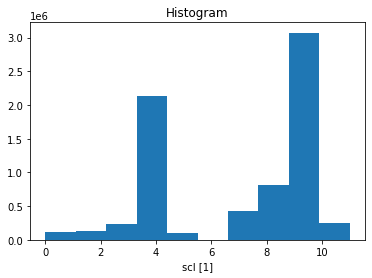

In [21]:
#check scene classification by indexing
dataset.scl.isel(time=range(141)).plot()

In [22]:
#look for snow scenes
snow = dataset.where(dataset.scl == 11, drop=True)
snow.time

<xarray.DataArray 'time' (time: 13)>
array(['2018-01-02T10:24:20.000000000', '2018-02-06T10:22:06.000000000',
       '2018-02-14T10:31:25.000000000', '2018-02-19T10:35:42.000000000',
       '2018-02-21T10:20:33.000000000', '2018-02-24T10:30:18.000000000',
       '2018-03-21T10:33:45.000000000', '2018-05-15T10:30:24.000000000',
       '2018-05-20T10:34:58.000000000', '2018-07-11T10:20:24.000000000',
       '2018-10-24T10:24:28.000000000', '2018-12-08T10:26:53.000000000',
       '2018-12-11T10:36:50.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-11T10:...
    spatial_ref  int32 25832
Attributes:
    units:    seconds since 1970-01-01 00:00:00

#### We can select data for an entire year by passing a string to .sel():

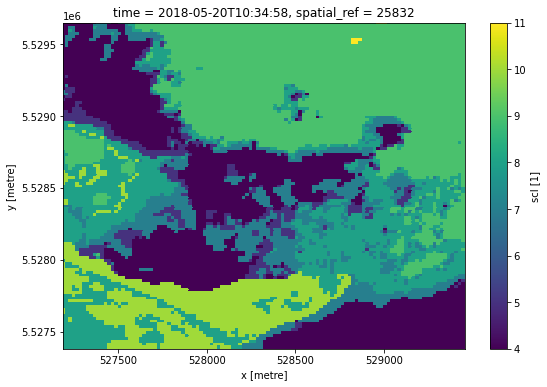

In [23]:
# may with snow
dataset.sel(time='2018-05-20').scl.plot(size=6)

In [24]:
# Indexing with dimension names
dataset.nir.sel(time='2018')

<xarray.DataArray 'nir' (time: 143, y: 227, x: 227)>
array([[[9088, 9032, 8920, ..., 9376, 9264, 9152],
        [9224, 9048, 9064, ..., 9224, 9176, 9176],
        [9336, 9224, 9152, ..., 9248, 9264, 9320],
        ...,
        [8536, 8728, 8640, ..., 9920, 9536, 9056],
        [8824, 8912, 8928, ..., 9568, 9192, 8736],
        [8880, 8920, 9056, ..., 9312, 8944, 8416]],

       [[4166, 4074, 3967, ..., 4934, 4815, 4886],
        [4047, 3920, 3860, ..., 5103, 4936, 4906],
        [3908, 3874, 3817, ..., 5115, 5040, 5077],
        ...,
        [4427, 4407, 4364, ..., 6057, 5904, 5880],
        [4474, 4388, 4319, ..., 6137, 5995, 5898],
        [4463, 4382, 4408, ..., 6279, 6146, 5995]],

       [[2178, 2058, 1994, ..., 2712, 2735, 2733],
        [2113, 1984, 1961, ..., 2696, 2679, 2726],
        [2029, 1985, 1948, ..., 2688, 2720, 2649],
        ...,
...
        ...,
        [1346, 1346, 1374, ..., 1854, 1512, 1512],
        [1382, 1324, 1368, ..., 1554, 1610, 1700],
        [1456, 1388, 1366, ..., 1688, 1888, 2110]],

       [[1315, 1182,  914, ..., 2884, 2928, 2361],
        [1780, 1064,  789, ..., 3056, 3248, 2684],
        [2228, 1622, 1206, ..., 3542, 3430, 2946],
        ...,
        [1538, 1846, 1782, ..., 1877, 1714, 1667],
        [1504, 1876, 1814, ..., 1824, 1908, 2098],
        [1664, 1980, 1822, ..., 1996, 2204, 2480]],

       [[7836, 7896, 8056, ..., 7964, 7980, 8080],
        [7552, 7680, 7796, ..., 8180, 8232, 8360],
        [7220, 7300, 7540, ..., 8512, 8656, 8704],
        ...,
        [5340, 5316, 5308, ..., 6632, 6376, 6164],
        [5428, 5392, 5284, ..., 6484, 6156, 6064],
        [5616, 5536, 5456, ..., 6292, 6148, 6012]]], dtype=int16)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-31T10:...
  * y            (y) float64 5.53e+06 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x            (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref  int32 25832
Attributes:
    units:         reflectance
    nodata:        -9999
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

Or select a single month:

In [25]:
dataset.red.sel(time='2018-06')

<xarray.DataArray 'red' (time: 9, y: 227, x: 227)>
array([[[  396,   437,   427, ...,   869,   907,   961],
        [  441,   410,   359, ...,   995,  1042,  1023],
        [  548,   395,   407, ...,  1094,  1112,  1026],
        ...,
        [ 5772,  5748,  5472, ...,  5156,  5260,  5112],
        [ 5668,  5568,  5448, ...,  5248,  5340,  5196],
        [ 5584,  5396,  5260, ...,  5280,  5304,  5208]],

       [[  224,   237,   203, ...,   363,   489,   733],
        [  293,   218,   197, ...,   328,   333,   434],
        [  402,   247,   243, ...,   360,   369,   379],
        ...,
        [  226,   214,   245, ...,   247,   255,   256],
        [  242,   228,   223, ...,   240,   239,   287],
        [  231,   225,   209, ...,   238,   260,   273]],

       [[ 7700,  7660,  8248, ...,  4124,  4212,  4252],
        [ 7936,  7984,  8400, ...,  4228,  4284,  4248],
        [ 8336,  8440,  8632, ...,  4248,  4252,  4112],
        ...,
...
        ...,
        [ 3548,  3560,  3552, ...,  3030,  2934,  2898],
        [ 3558,  3554,  3586, ...,  3044,  2968,  2912],
        [ 3594,  3602,  3618, ...,  2814,  2770,  2744]],

       [[10128, 10016,  9816, ..., 10160, 10176, 10072],
        [ 9856,  9712,  9568, ..., 10216, 10088, 10072],
        [ 9472,  9376,  9344, ..., 10160,  9992,  9976],
        ...,
        [ 6844,  6888,  6988, ..., 10448, 10496, 10544],
        [ 6772,  6860,  6988, ..., 10576, 10632, 10560],
        [ 6836,  6964,  7044, ..., 10592, 10664, 10624]],

       [[  471,   507,   500, ...,   614,   816,   948],
        [  430,   423,   428, ...,   551,   578,   863],
        [  444,   410,   407, ...,   548,   510,   589],
        ...,
        [ 4640,  4018,  3596, ...,  1730,  1788,  1808],
        [ 5084,  4428,  3852, ...,  1704,  1758,  1786],
        [ 4884,  4552,  4188, ...,  1688,  1722,  1762]]], dtype=int16)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-01T10:20:24 ... 2018-06-29T10:...
  * y            (y) float64 5.53e+06 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x            (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref  int32 25832
Attributes:
    units:         reflectance
    nodata:        -9999
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

Or a specific date

Or select a range of dates using slice(). This selects all observations between the two dates, inclusive of both the start and stop values:

In [26]:
dataset.red.sel(time=slice('2018-02-10', '2018-04-10'))

<xarray.DataArray 'red' (time: 23, y: 227, x: 227)>
array([[[ 6203,  6051,  5799, ...,  6777,  6796,  6824],
        [ 6226,  6085,  5833, ...,  6772,  6860,  6763],
        [ 6207,  5970,  5736, ...,  6820,  6879,  6873],
        ...,
        [ 5773,  5635,  5611, ...,  6983,  6969,  6906],
        [ 5859,  5706,  5607, ...,  7144,  7118,  7127],
        [ 5729,  5608,  5502, ...,  7234,  7171,  7193]],

       [[  709,   686,   555, ...,   703,  1171,  3211],
        [  448,   622,   622, ...,   837,   887,  1965],
        [  590,   451,   421, ...,   903,   953,  1121],
        ...,
        [ 1249,  1332,  1448, ...,   119,   100,   102],
        [ 1215,  1355,  1271, ...,    66,   116,   122],
        [ 1245,  1494,  1352, ...,    76,   146,   134]],

       [[ 4962,  4767,  4540, ..., 10567,  9788,  9170],
        [ 4934,  4623,  4380, ..., 10044,  9152,  8249],
        [ 4742,  4569,  4379, ...,  9311,  8307,  7022],
        ...,
...
        ...,
        [ 8863,  8863,  8765, ..., 10740, 10755, 10854],
        [ 8856,  8852,  8768, ..., 10795, 10829, 10864],
        [ 8822,  8814,  8799, ..., 10787, 10869, 10877]],

       [[  380,   413,   403, ...,   394,   420,   914],
        [  255,   239,   374, ...,   356,   512,   760],
        [  246,   162,   284, ...,   364,   555,   609],
        ...,
        [  697,   677,   671, ...,   246,   199,   170],
        [  683,   668,   739, ...,   245,   204,   162],
        [  654,   698,   842, ...,   281,   187,   191]],

       [[ 3518,  3571,  3582, ...,  2471,  2498,  2532],
        [ 3529,  3571,  3565, ...,  2413,  2467,  2527],
        [ 3509,  3523,  3547, ...,  2374,  2395,  2440],
        ...,
        [ 4058,  4101,  4107, ...,  4913,  4912,  4901],
        [ 4122,  4170,  4140, ...,  4907,  4919,  4914],
        [ 4125,  4157,  4145, ...,  4949,  4914,  4914]]], dtype=int16)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-11T10:25:59 ... 2018-04-10T10:...
  * y            (y) float64 5.53e+06 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x            (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref  int32 25832
Attributes:
    units:         reflectance
    nodata:        -9999
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

getting additional information, e.g. seasons

In [27]:
dataset.time.dt.season

<xarray.DataArray 'season' (time: 143)>
array(['DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
       'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
       'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'MAM',
       'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM',
       'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM',
       'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM',
       'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'JJA',
       'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA',
       'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA',
       'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA',
       'JJA', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'SON', 'SON',
       'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON',
       'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON',
       'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON', 'SON',
       'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
       'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF'],
      dtype='<U3')
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-31T10:...
    spatial_ref  int32 25832

Or the day of the year:

In [28]:
dataset.time.dt.dayofyear

<xarray.DataArray 'dayofyear' (time: 143)>
array([  2,   5,   7,  10,  12,  15,  17,  20,  22,  25,  27,  30,  32,
        35,  37,  40,  42,  45,  47,  50,  52,  55,  57,  60,  62,  65,
        70,  72,  75,  77,  80,  82,  85,  87,  90,  92,  95,  97, 100,
       102, 105, 107, 110, 112, 115, 117, 120, 122, 125, 127, 127, 130,
       132, 135, 137, 140, 142, 145, 150, 152, 155, 165, 167, 170, 172,
       175, 177, 180, 182, 185, 187, 190, 192, 195, 197, 200, 202, 205,
       207, 210, 212, 212, 215, 217, 220, 222, 225, 227, 230, 232, 235,
       237, 240, 242, 245, 247, 250, 252, 255, 257, 260, 262, 265, 267,
       270, 272, 275, 277, 280, 282, 285, 287, 290, 292, 295, 297, 300,
       302, 305, 307, 310, 312, 315, 320, 322, 325, 327, 330, 332, 335,
       337, 340, 342, 345, 347, 350, 352, 355, 355, 357, 360, 362, 365])
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-31T10:...
    spatial_ref  int32 25832

xarray also provides some shortcuts for aggregating data over time. In the example below, we first group our data by season, then take the median of each group. This produces a new dataset with only four observations (one per season)

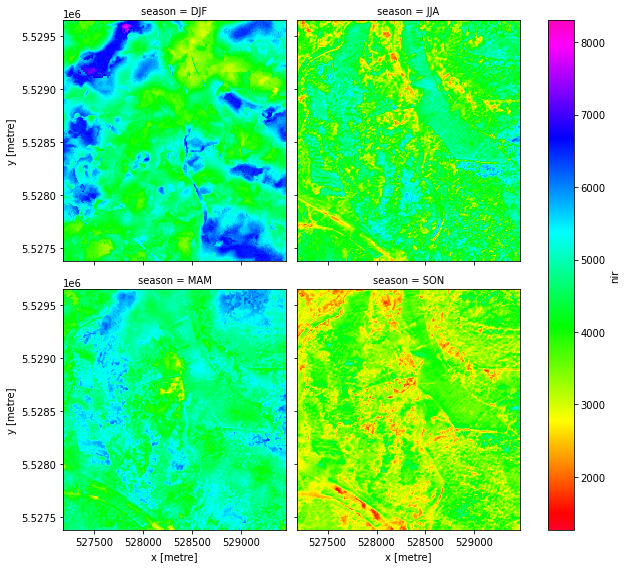

In [29]:
# Group the time series into seasons, and take median of each time period
ds_seasonal = dataset.groupby('time.season').median(dim='time')

# Plot the output
ds_seasonal.nir.plot(col='season', col_wrap=2, size=4, cmap='gist_rainbow')
plt.show()

We can also use the .resample() method to summarise our dataset into different chunks of time. E.g. 2 months median-composite:

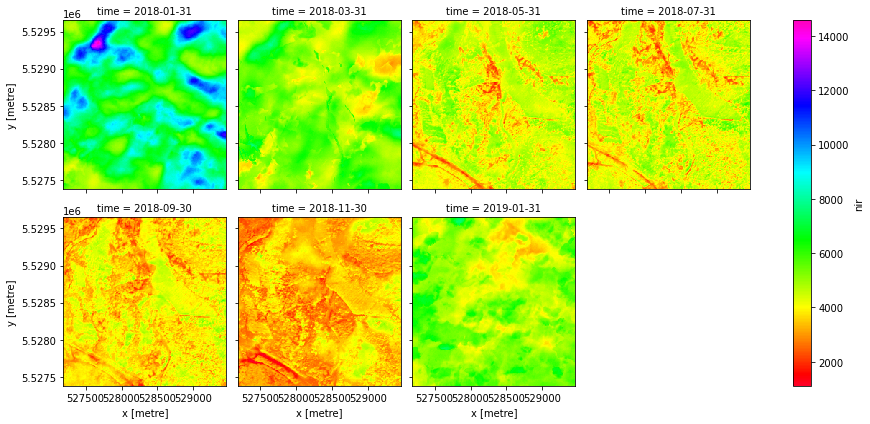

In [30]:
# Resample to combine each 2 months of data into a median composite
ds_resampled = dataset.resample(time='2m').median()

# Plot the new resampled data
ds_resampled.nir.plot(col='time', col_wrap=4,cmap='gist_rainbow')
plt.show()

Sometimes, we want to return data for specific times/dates that weren't observed by a satellite. To estimate what the landscape appeared like on certain dates, we can use the .interp() method to interpolate between the nearest two observations.

In [31]:
dataset.time.sel(time='2018-08')

<xarray.DataArray 'time' (time: 12)>
array(['2018-08-03T10:32:39.000000000', '2018-08-05T10:20:19.000000000',
       '2018-08-08T10:34:48.000000000', '2018-08-10T10:20:23.000000000',
       '2018-08-13T10:30:21.000000000', '2018-08-15T10:20:17.000000000',
       '2018-08-18T10:30:15.000000000', '2018-08-20T10:23:58.000000000',
       '2018-08-23T10:35:35.000000000', '2018-08-25T10:20:15.000000000',
       '2018-08-28T10:30:13.000000000', '2018-08-30T10:25:24.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2018-08-03T10:32:39 ... 2018-08-30T10:...
    spatial_ref  int32 25832
Attributes:
    units:    seconds since 1970-01-01 00:00:00

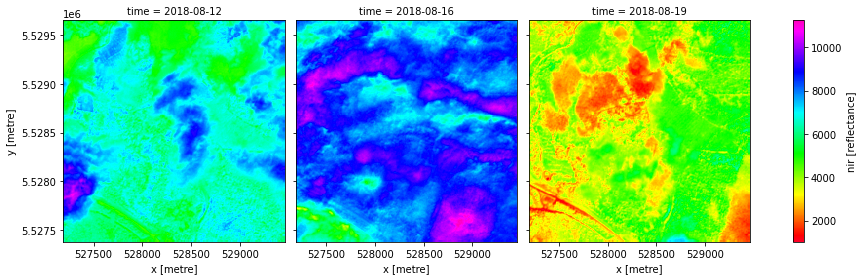

In [32]:
# New dates to interpolate data for
new_dates = ['2018-08-12', '2018-08-16', '2018-08-19']

# Interpolate Landsat values for three new dates
ds_interp = dataset.interp(time=new_dates)

# Plot the new interpolated data
ds_interp.nir.plot(col='time', cmap='gist_rainbow', size=4)
plt.show()

### Basic math

In [33]:
#Calculate NDVI
ndvi = (dataset.nir - dataset.red)/(dataset.nir + dataset.red)
# set values > -0.1 to 0
ndvi_lowneg = xr.where(ndvi > -0.1 ,ndvi, 0)
ndvi_lowneg

<xarray.DataArray (time: 143, y: 227, x: 227)>
array([[[ 2.25022502e-02,  1.84934596e-02,  8.59339665e-03, ...,
          1.73611111e-02,  1.84696570e-02,  9.70873786e-03],
        [ 1.67548501e-02,  1.93780982e-02,  2.30248307e-02, ...,
          1.14035088e-02,  1.10180696e-02,  1.19100132e-02],
        [ 2.45829675e-02,  2.62572319e-02,  2.69299820e-02, ...,
          6.96864111e-03,  1.00305277e-02,  1.43665651e-02],
        ...,
        [ 2.17859708e-02,  3.70722433e-02,  4.49927431e-02, ...,
          2.14168040e-02,  2.27370227e-02,  1.43369176e-02],
        [ 1.94085028e-02,  2.43678161e-02,  2.71514036e-02, ...,
          1.70068027e-02,  1.86170213e-02,  7.84494693e-03],
        [ 9.01713255e-04,  2.24719101e-03,  1.34288272e-02, ...,
          2.06049978e-02,  1.86788155e-02,  9.51474786e-04]],

       [[-1.43144446e-02, -1.02040816e-02, -2.26656812e-02, ...,
         -1.49730485e-02, -1.29151292e-02, -9.12593794e-03],
        [-1.70026718e-02, -2.00000000e-02, -1.65605096e-02, ...,
          9.79911808e-05, -1.07225173e-02, -1.51560775e-02],
        [-2.54364090e-02, -1.34963076e-02, -9.98573466e-03, ...,
         -3.79783815e-03, -8.16687986e-03,  1.77584846e-03],
...
        [ 1.00930565e-01,  9.81558596e-02,  1.09589041e-01, ...,
          5.24157531e-01,  6.52048193e-01,  6.30317848e-01],
        [ 8.04597701e-02,  8.75362319e-02,  1.12201104e-01, ...,
          5.07438017e-01,  6.21070518e-01,  6.44200627e-01],
        [ 9.54575379e-02,  1.11111111e-01,  1.19164619e-01, ...,
          4.71433837e-01,  5.77666428e-01,  6.57200134e-01]],

       [[-1.03561505e-02, -1.07742420e-02, -1.51589242e-02, ...,
         -2.61677672e-02, -2.46883403e-02, -2.55668114e-02],
        [-3.69393140e-03, -2.85640093e-03, -1.46612740e-02, ...,
         -3.51497995e-02, -2.83286119e-02, -2.65486726e-02],
        [-4.41257584e-03, -9.49796472e-03, -6.32577754e-03, ...,
         -3.09653916e-02, -1.90389846e-02, -2.37774787e-02],
        ...,
        [-3.12046444e-02, -3.23989807e-02, -2.99707602e-02, ...,
         -2.58519389e-02, -2.38824250e-02, -2.37567311e-02],
        [-3.20970043e-02, -3.78301213e-02, -3.47095360e-02, ...,
         -2.26107929e-02, -3.38983051e-02, -3.19284802e-02],
        [-2.83737024e-02, -3.82209868e-02, -4.17983843e-02, ...,
         -2.90123457e-02, -3.72690260e-02, -3.65384615e-02]]])
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-31T10:...
  * y            (y) float64 5.53e+06 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x            (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref  int32 25832

In [34]:
# Adding new data to DataSet
dataset['NDVI'] = ndvi_lowneg
dataset

<xarray.Dataset>
Dimensions:          (time: 143, x: 227, y: 227)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-02T10:24:20 ... 2018-12-31...
  * y                (y) float64 5.53e+06 5.53e+06 ... 5.527e+06 5.527e+06
  * x                (x) float64 5.272e+05 5.272e+05 ... 5.294e+05 5.295e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) int16 9680 9680 9680 9250 ... 9087 8356 8356
    blue             (time, y, x) int16 9280 9080 8960 8880 ... 7684 7596 7524
    green            (time, y, x) int16 8736 8632 8504 8400 ... 6988 6860 6688
    red              (time, y, x) int16 8688 8704 8768 8808 ... 6668 6624 6468
    red_edge1        (time, y, x) int16 9029 9029 9029 9204 ... 7117 6637 6637
    red_edge2        (time, y, x) int16 8820 8935 8935 9137 ... 6836 6410 6410
    red_edge3        (time, y, x) int16 8837 8818 8818 8971 ... 6649 6260 6260
    nir              (time, y, x) int16 9088 9032 8920 8832 ... 6292 6148 6012
    narrow_nir       (time, y, x) int16 8845 8941 8941 8891 ... 6601 6201 6201
    water_vapour     (time, y, x) int16 8787 8787 8787 8141 ... 7644 6492 6492
    swir1            (time, y, x) int16 4750 4808 4808 4925 ... 3880 3577 3577
    swir2            (time, y, x) int16 4018 4196 4196 4201 ... 2605 2278 2278
    scl              (time, y, x) uint8 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9
    NDVI             (time, y, x) float64 0.0225 0.01849 ... -0.03727 -0.03654
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

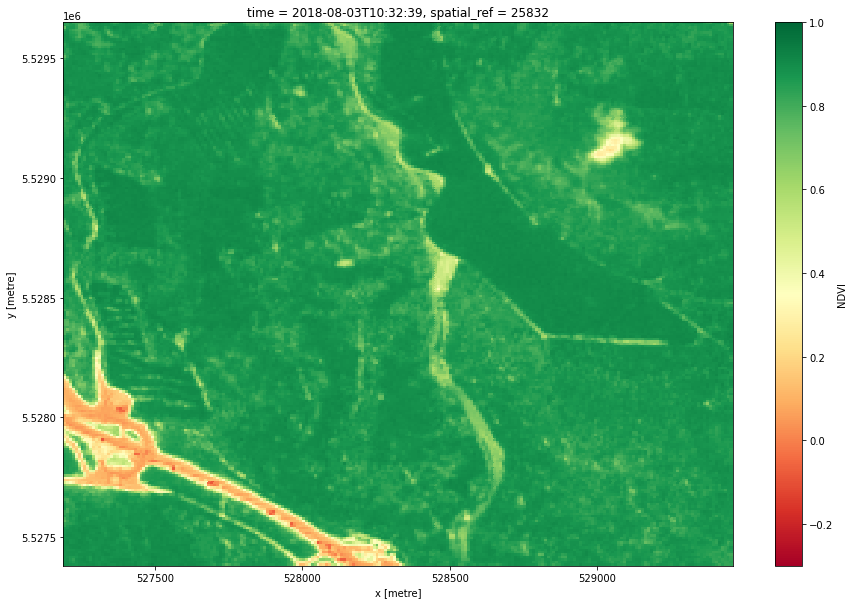

In [35]:
dataset.NDVI.sel(time='2018-08-03').plot(size=10, cmap='RdYlGn', vmax = 1, vmin=-0.3)

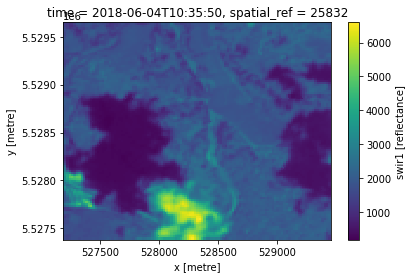

In [37]:
dataset.swir1.isel(time=60).plot()

## Preprocessing satellite data

### Check cloud coverage

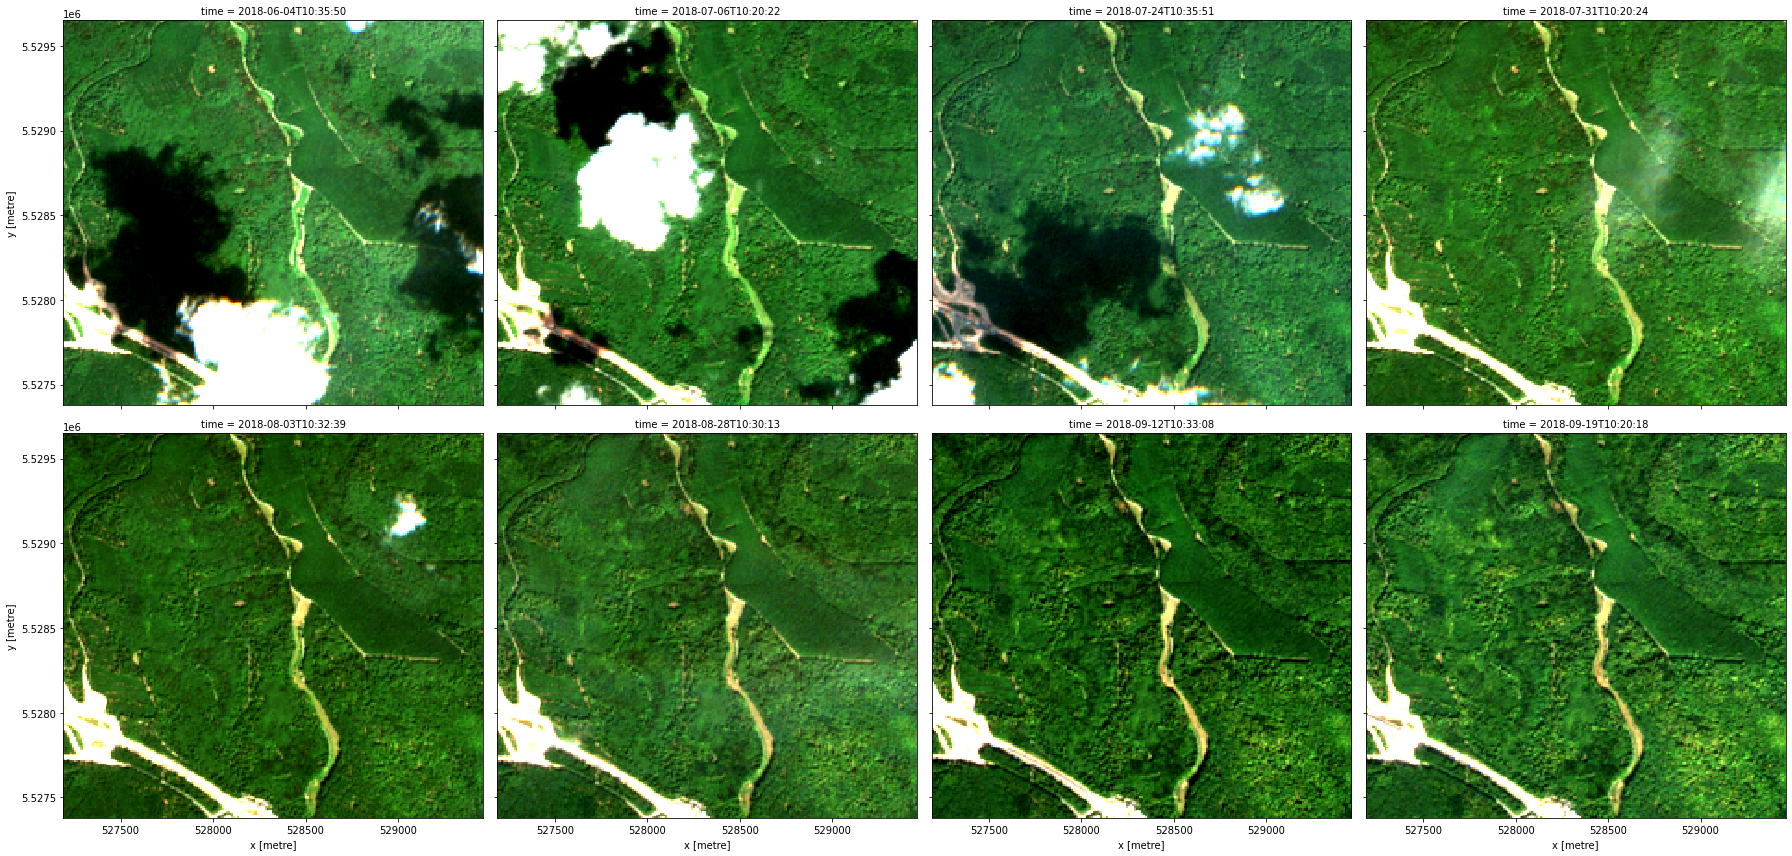

In [38]:
rgb(dataset, bands=['red', 'green', 'blue'], index=[60,70,77,80,82,92,98,101],robust=True, percentile_stretch = (0.05, 0.95))

In [83]:
from functools import partial 
#from utils.data_cube_utilities.s2fn import s2_unpack_scl


def s2_clean_mask(ds, bands):
    masks = [s2_unpack_scl(ds, band) for band in bands]
    return np.logical_or(*masks).values

def s2_cct(dataset):
    times  = list(dataset.time.values)
    scene_slice_list = list(map(lambda t: dataset.isel(time = t).scl, times))
    clean_mask_list = list(map(partial(s2_clean_mask, bands = ['cloud_free','water']), scene_slice_list))
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    percentage_list = list(map(lambda x:np.sum(x)/(x.shape[0] * x.shape[1]), clean_mask_list))

    data = {"times": times,
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])


def unpack_s2bits(s2_scl_endcoding, data_array, cover_type):
    boolean_mask = np.isin(data_array.values, s2_scl_endcoding[cover_type]) 
    return xr.DataArray(boolean_mask.astype(bool),
                        coords = data_array.coords,
                        dims = data_array.dims,
                        name = cover_type + "_mask",
                        attrs = data_array.attrs)

def s2_unpack_scl(data_array , cover_type):
    s2_scl_endcoding = dict(no_data                       =[0],
                                saturated_or_defective        =[1],
                                dark_area_pixels              =[2],
                                cloud_shadows                 =[3],
                                vegetation                    =[4],
                                not_vegetated                 =[5],
                                water                         =[6],
                                unclassified                  =[7],
                                cloud_medium_probability      =[8],
                                cloud_high_probability        =[9],
                                thin_cirrus                   =[10],
                                snow                          =[11],
                                cloud                         =[3,8,9,10],
                                cloud_free                    =[4,5,6]
                               )
    return unpack_s2bits(s2_scl_endcoding, data_array, cover_type)

In [81]:
#from functools import partial
#import numpy as np

In [39]:
mask = s2_unpack_scl(dataset.scl, 'cloud_free')
clean_dataset = dataset.where(mask)

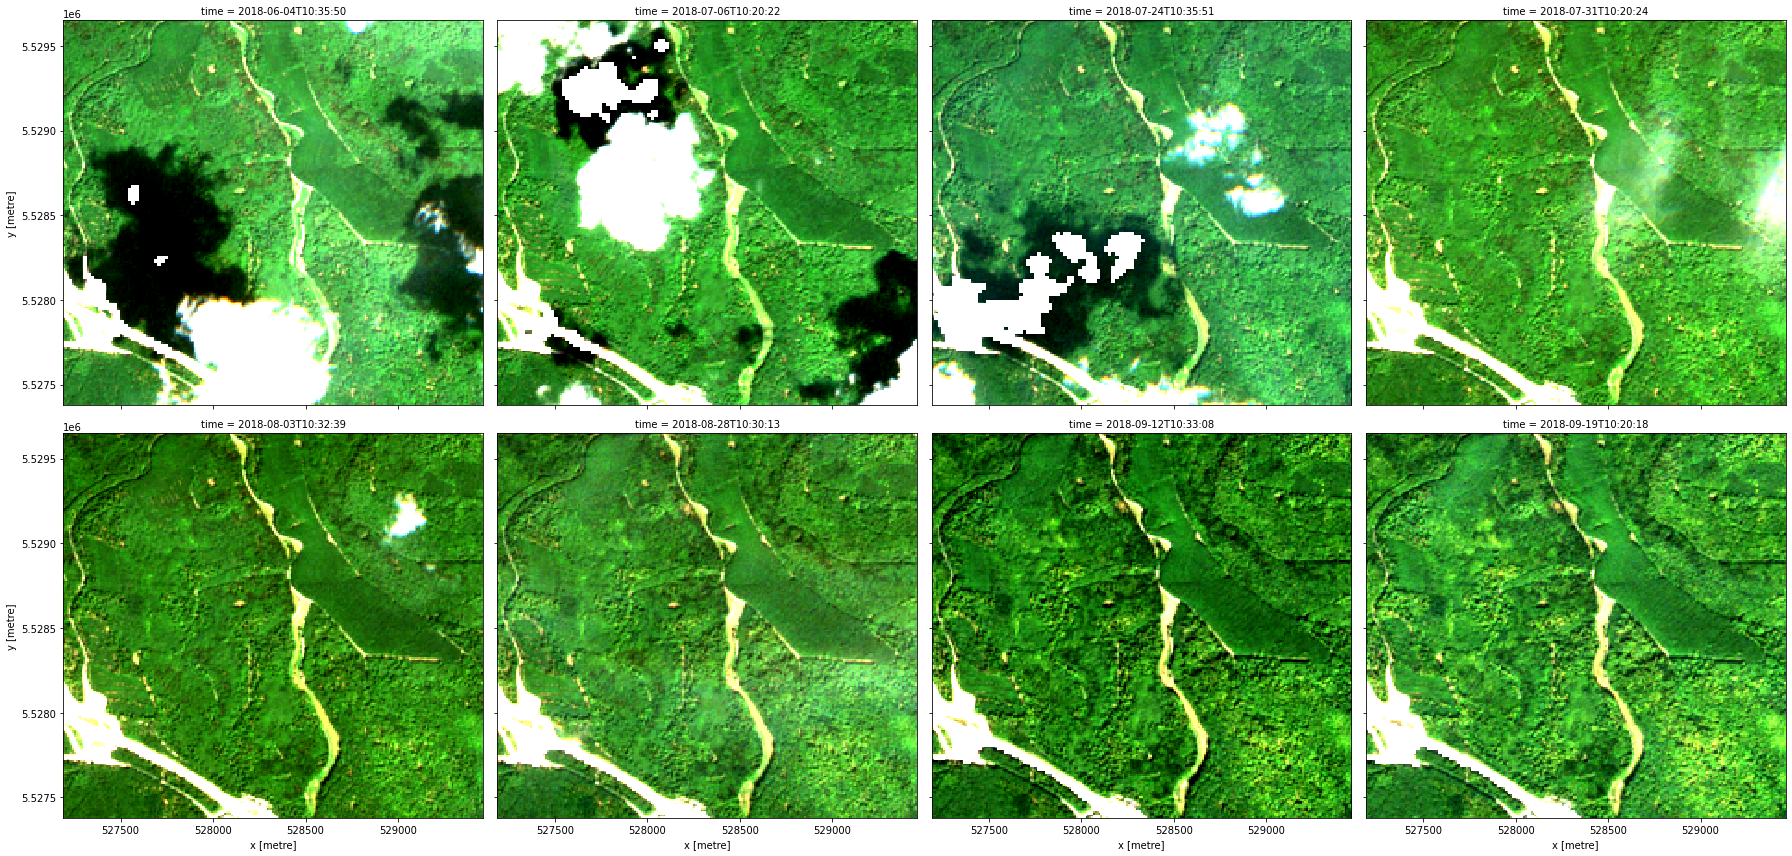

In [40]:
rgb(clean_dataset, bands=['red', 'green', 'blue'], index=[60,70,77,80,82,92,98,101],robust=True, percentile_stretch = (0.05, 0.95))

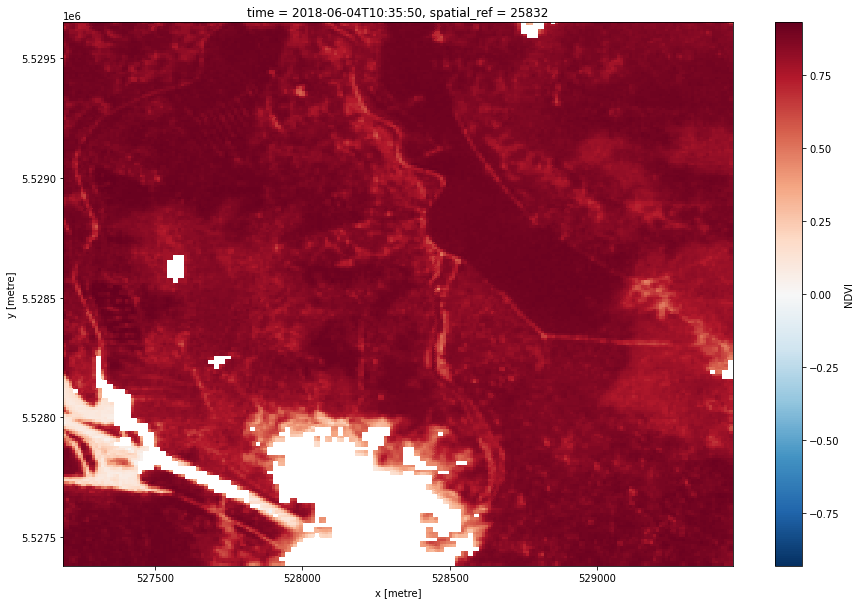

In [44]:
clean_dataset.NDVI.isel(time=60).plot(size=10)

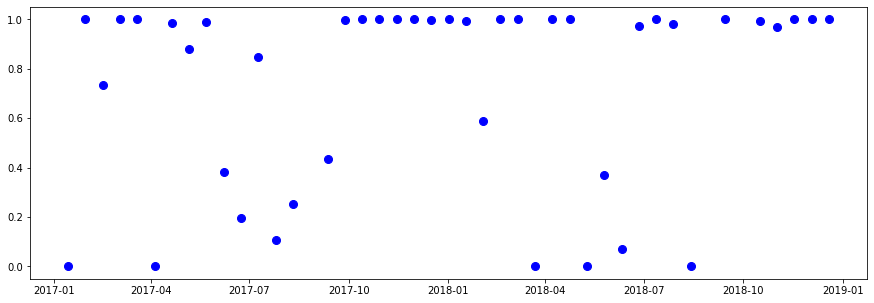

In [42]:
%matplotlib inline

plt.figure(figsize = (15,5))
plt.plot(cc_table["times"].values, cc_table["clean_percentage"].values, 'bo', markersize=8)
plt.show()

### Remove clouds from dataset

In [243]:
#from utils.data_cube_utilities.s2fn import s2_unpack_scl
#Make a Clean Mask to remove clouds and scanlines
mask = s2_unpack_scl(dataset, 'cloud_free')

#Filter the scenes with that clean mask
clean_dataset = dataset.where(mask)
#mask=np.invert(mask)

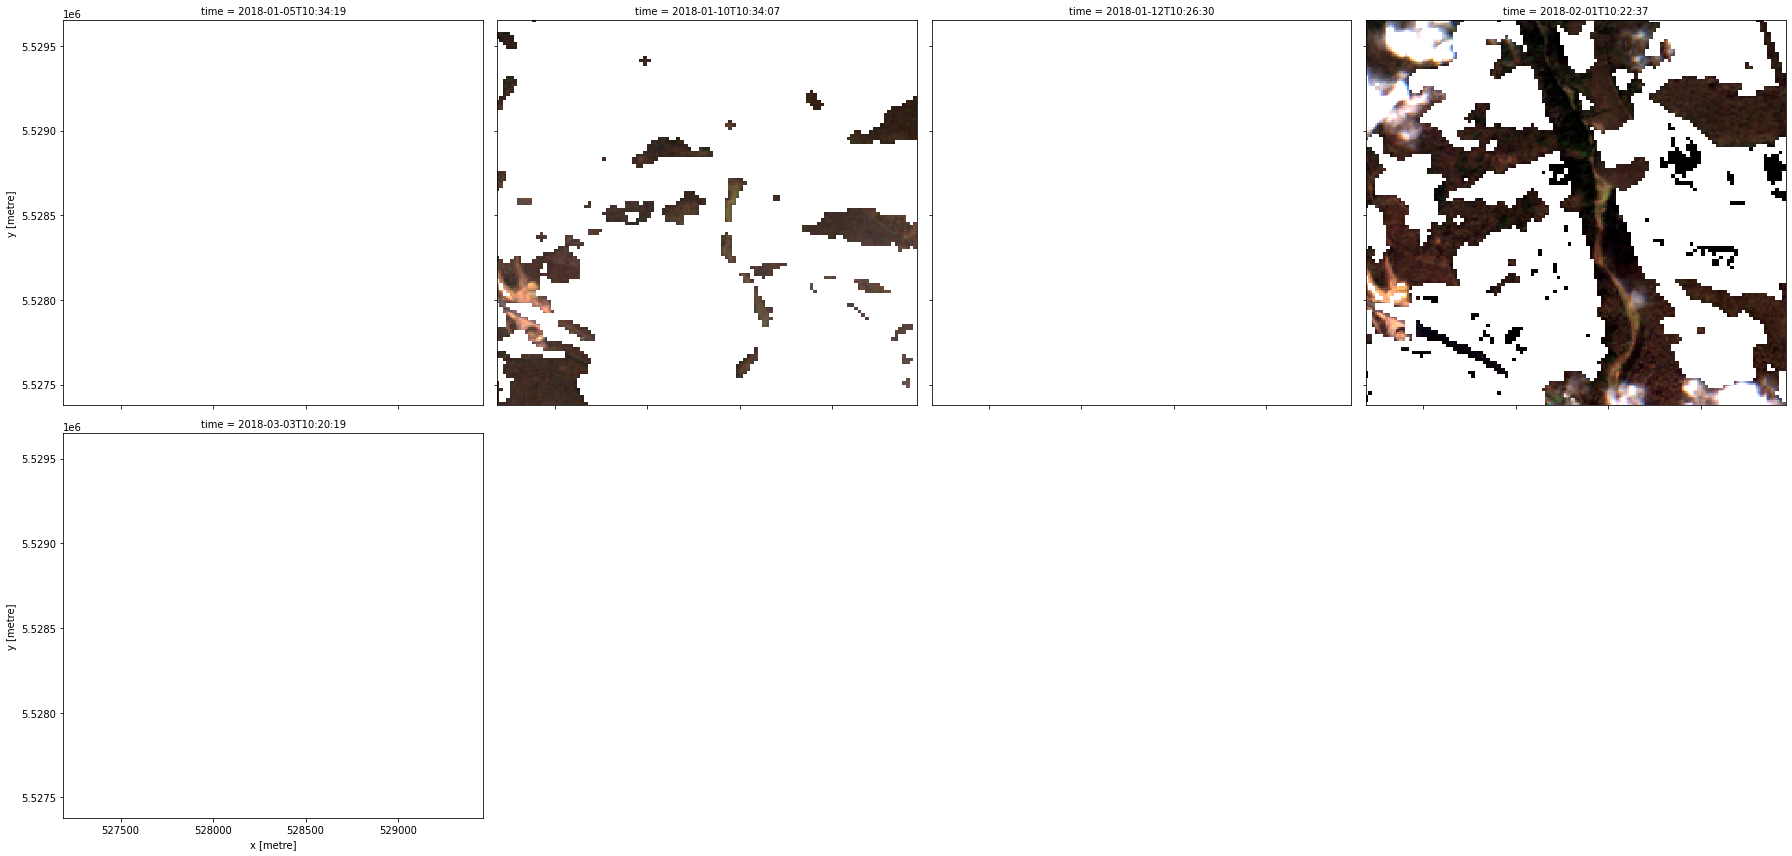

In [244]:
rgb(clean_dataset, bands=['red', 'green', 'blue'], index=[1,3,4,12,24])

## Creating cloud free composites

**Most Recent Pixel Mosaic**

Masks clouds from imagery and uses the most recent cloud-free pixels.

In [45]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic

recent_composite = create_mosaic(dataset, clean_mask = mask)

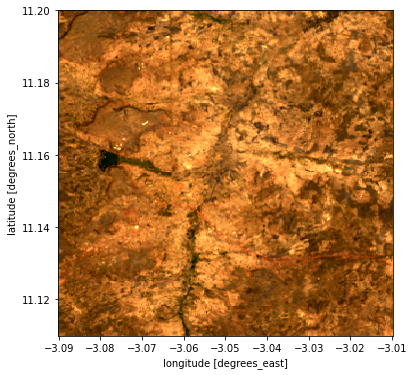

In [46]:
rgb(recent_composite)

**Median Mosaic**

Masks clouds from imagery using the median-valued cloud-free pixels in the time series. More specifically, each band (e.g. red) of each pixel is assigned its median across time. So this mosaic method generates values that are not in the dataset.


In [47]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

median_composite = create_median_mosaic(dataset, mask)

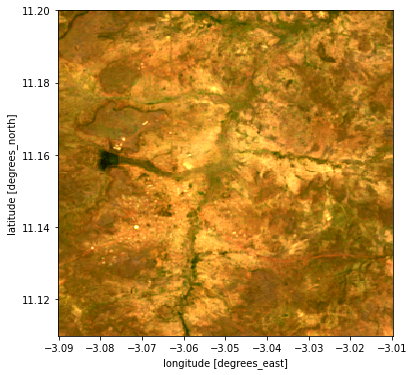

In [48]:
rgb(median_composite)

## Perform K-Means clustering

In [49]:
#cluster_bands = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir']
cluster_bands = ['red', 'green', 'blue']

In [50]:
from utils.data_cube_utilities.dc_clustering import kmeans_cluster_dataset

classification_x =  kmeans_cluster_dataset(median_composite, cluster_bands, n_clusters=4)

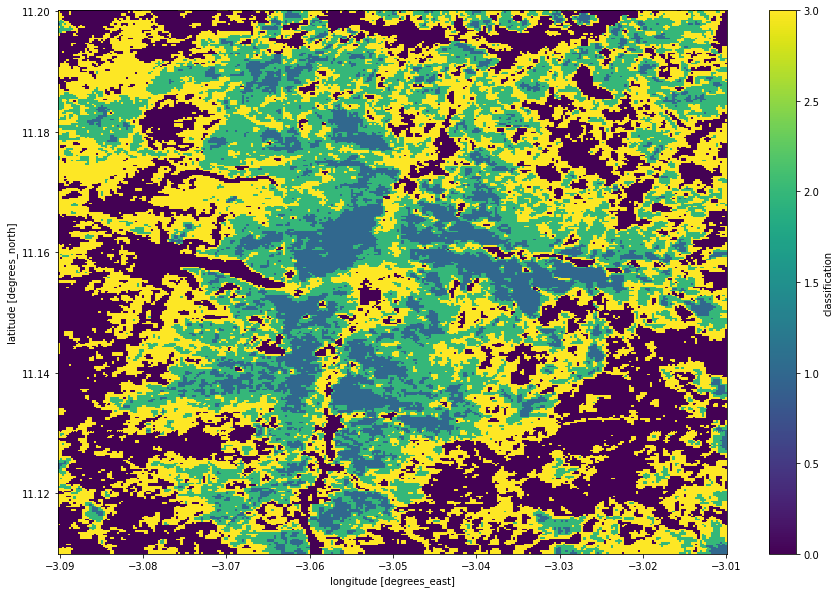

In [51]:
# plot the k-mean classification result 
classification_x.classification.plot(size=10)

In [ ]:
# classification_x =  kmeans_cluster_dataset(dataset, cluster_bands, n_clusters=4)

## Fractional Cover

Fractional Cover represents the proportion of the land surface that is bare (BS), covered by photosynthetic vegetation (PV), or non-photosynthetic vegetation (NPV).


 <img src="images/frac2.png"  width=400 align=right /> 

**Bare Soil** (bare ground, rock, disturbed) (BS): - Bare Ground (bare soil, rock) percentage; Digital Number 10000 = 100%

**Photosythetic Vegetation** (green grass, trees, etc.) (PV): - Photosynthetic Vegetation: Green Vegetation percentage;Digital Number 10000 = 100%

**Non-Photosythetic vegetation** (litter, dead leaf and branches) (NPV): - Non-Photosynthetic Vegetation (litter, dead leaves andbranches) percentage; Digital Number 10000 = 100%

**Unmixing Error** : - Unmixing Error. The residual error, defined as the Euclidean Norm of the Residual Vector. High values express less confidence in the fractional components



In [77]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify

frac_classes = frac_coverage_classify(median_composite, clean_mask = np.ones(median_composite.pixel_qa.shape).astype(np.bool))

In [53]:
frac_classes

<xarray.Dataset>
Dimensions:    (latitude: 330, longitude: 294)
Coordinates:
  * latitude   (latitude) float64 11.2 11.2 11.2 11.2 ... 11.11 11.11 11.11
  * longitude  (longitude) float64 -3.09 -3.09 -3.09 ... -3.011 -3.01 -3.01
Data variables:
    bs         (latitude, longitude) float32 22.0 15.0 17.0 ... 30.0 26.0 30.0
    pv         (latitude, longitude) float32 39.0 41.0 39.0 ... 18.0 18.0 18.0
    npv        (latitude, longitude) float32 35.0 40.0 40.0 ... 48.0 52.0 48.0

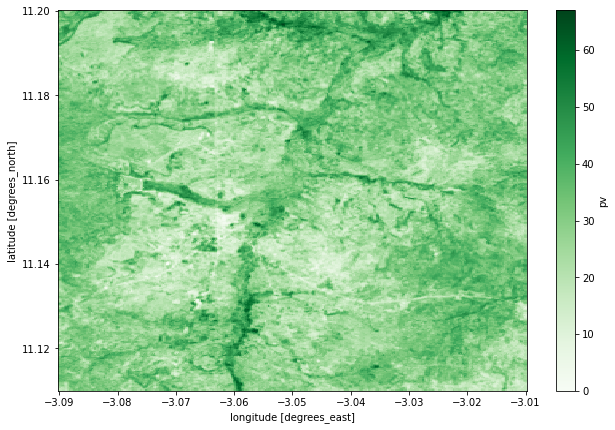

In [54]:
frac_classes.pv.plot(cmap = "Greens", size=7)

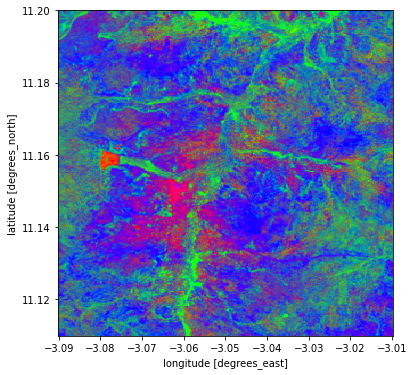

In [55]:
rgb(frac_classes, bands = ['bs', 'pv', 'npv'])

## Spectral indices

In [56]:
 # Normalised Difference Vegation Index, Rouse 1973
ndvi = (dataset_clean.nir - dataset_clean.red)/(dataset_clean.nir + dataset.red)

# Enhanced Vegetation Index, Huete 2002
evi = 2.5*(dataset_clean.nir - dataset_clean.red)/((dataset_clean.nir + 6*dataset_clean.red-7.5*dataset_clean.blue)+1)

# Soil Adjusted Vegetation Index, Huete 1988
savi = (1.5 * (dataset_clean.nir -dataset_clean.red)) /(dataset_clean.nir + dataset.red + 0.5)

In [58]:
## Using a function 
from utils.data_cube_utilities.spectral_indices import calculate_indices

calculate_indices(dataset_clean,indices = ['NDVI', 'EVI', 'SAVI'], normalise = False)

<xarray.Dataset>
Dimensions:    (latitude: 330, longitude: 294, time: 42)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-14T10:32:48 ... 2018-12-19T10:32:31
  * latitude   (latitude) float64 11.2 11.2 11.2 11.2 ... 11.11 11.11 11.11
  * longitude  (longitude) float64 -3.09 -3.09 -3.09 ... -3.011 -3.01 -3.01
Data variables:
    red        (time, latitude, longitude) float64 nan nan ... 1.407e+03
    green      (time, latitude, longitude) float64 nan nan ... 1.01e+03
    blue       (time, latitude, longitude) float64 nan nan nan ... 629.0 627.0
    nir        (time, latitude, longitude) float64 nan nan ... 2.349e+03
    swir1      (time, latitude, longitude) float64 nan nan ... 3.208e+03
    swir2      (time, latitude, longitude) float64 nan nan ... 2.334e+03
    pixel_qa   (time, latitude, longitude) float64 nan nan nan ... 322.0 322.0
    NDVI       (time, latitude, longitude) float64 nan nan nan ... 0.2458 0.2508
    EVI        (time, latitude, longitude) float64 nan nan nan ... 0.376 0.3867
    SAVI       (time, latitude, longitude) float64 nan nan nan ... 0.3686 0.3761
Attributes:
    crs:      EPSG:4326

In [59]:
spatial_mean = dataset_clean.mean(dim = ('longitude', 'latitude')).to_dataframe()
plot_df = spatial_mean[['NDVI', 'SAVI']] # select only preselected indices (default: ndvi, evi)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


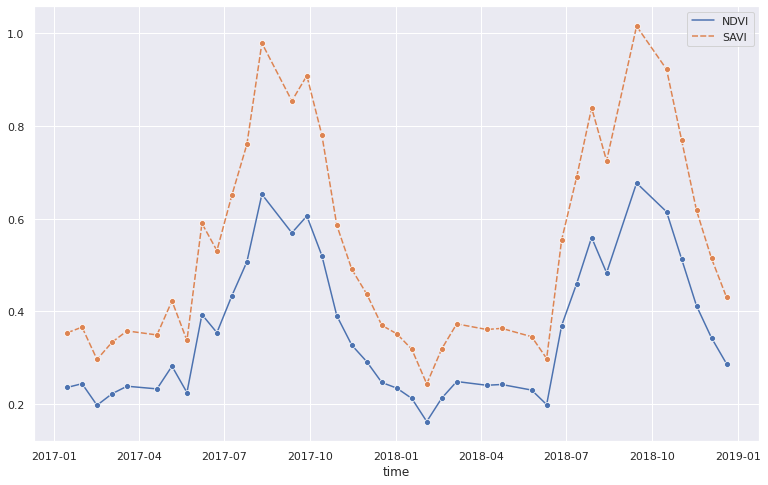

In [60]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(13,8))
ax = sns.lineplot(data=plot_df,marker="o")

In [61]:
#Cast to pandas dataframe
df = dataset_clean['NDVI'].to_dataframe("ndvi")
#flatten the dimensions since it is a compound hierarchical dataframe
df = df.stack().reset_index()
#Drop the junk column that was generated for NDVI
df = df.drop(["level_3"], axis=1)
#Preview first 5 rows to make sure everything looks as it should
df.head()

time   latitude  longitude         0
0 2017-01-14 10:32:48  11.171570  -3.013804  0.198307
1 2017-01-14 10:32:48  11.171296  -3.014077  0.204406
2 2017-01-14 10:32:48  11.171296  -3.013804  0.214286
3 2017-01-14 10:32:48  11.171023  -3.014077  0.226320
4 2017-01-14 10:32:48  11.171023  -3.013804  0.241845

In [62]:
#Rename the NDVI column to the appropriate name
df = df.rename(index=str, columns={0: "ndvi"})
#clamp NDVI between 0 and 1
df.ndvi = df.ndvi.clip_lower(-1)
df.ndvi = df.ndvi.clip_upper(1)
#Add columns for Month and Year for convenience
df["Month"] = df.time.dt.month
df["Year"] = df.time.dt.year
#Preview changes
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  """


time   latitude  longitude      ndvi  Month  Year
0 2017-01-14 10:32:48  11.171570  -3.013804  0.198307      1  2017
1 2017-01-14 10:32:48  11.171296  -3.014077  0.204406      1  2017
2 2017-01-14 10:32:48  11.171296  -3.013804  0.214286      1  2017
3 2017-01-14 10:32:48  11.171023  -3.014077  0.226320      1  2017
4 2017-01-14 10:32:48  11.171023  -3.013804  0.241845      1  2017

In [63]:
df1= df.groupby('Year')['ndvi'].agg([pd.np.min, pd.np.max, pd.np.mean])
df1=df1.reset_index()

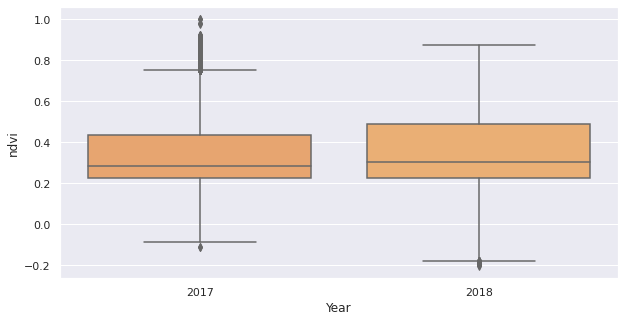

In [64]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))

median_vals = df.groupby('Year')['ndvi'].median()
norm = plt.Normalize(median_vals.min(), median_vals.max())
colors = plt.cm.RdYlGn(median_vals)

sns_plot = sns.boxplot(x='Year', y='ndvi', data=df  ,palette=colors)
s=sns_plot.get_figure()

In [65]:
df1= df.groupby('Month')['ndvi'].agg([pd.np.min, pd.np.max, pd.np.mean])
df1=df1.reset_index()

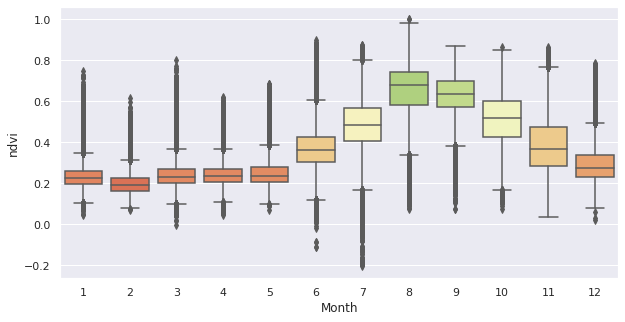

In [66]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))

median_vals = df.groupby('Month')['ndvi'].median()
norm = plt.Normalize(median_vals.min(), median_vals.max())
colors = plt.cm.RdYlGn(median_vals)

sns_plot = sns.boxplot(x='Month', y='ndvi', data=df  ,palette=colors)
s=sns_plot.get_figure()

### Extract from polygon

In [67]:
import utils.data_cube_utilities.spectral_indices as si

si.draw_geometry(latitude_extents,longitude_extents)

In [68]:
print(si.EXEC_RESULT)

Geometry successfully created


Polygon Time Series:


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


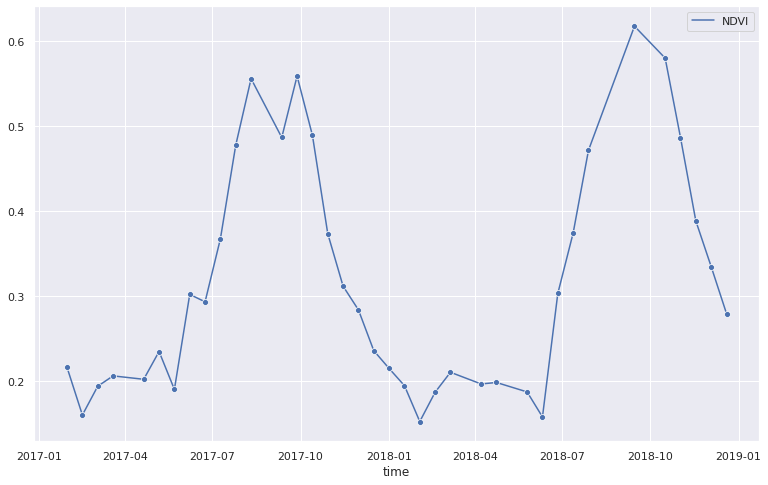

In [69]:
plot_df = si.extract_timeseries(si.GEOM, dataset_clean, layer=['NDVI']) # indices list can be added

##### plot time series
sns.set(style="darkgrid")
ax = plt.figure(figsize=(13,8))
ax = sns.lineplot(data=plot_df,marker="o")


### View the Baseline Averages Binned by Month

In [70]:
#Make labels for convenience
labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

#Initialize an empty pandas Series
df["z_score"] = pd.Series()

#declare list for population
binned_data = list()

#Calculate monthly binned z-scores from the composited monthly NDVI mean and store them
for i in range(12):
    
    #grab z_score and NDVI for the appropriate month
    temp  = df[["z_score", "ndvi"]][df["Month"] == i+1]
    
    #populate z_score
    df.loc[df["Month"] == i+1,"z_score"] = (temp["ndvi"] - temp["ndvi"].mean())/temp["ndvi"].std(ddof=0)
    
    #print the month next to its mean NDVI and standard deviation
    binned_data.append((labels[i], temp["ndvi"].mean(), temp["ndvi"].std()))

#Create dataframe for binned values
binned_data = pd.DataFrame.from_records(binned_data, columns=["Month","Mean", "Std_Dev"])
    
#print description for clarification
print("Monthly Average NDVI over Baseline Period")

#display binned data
binned_data

Monthly Average NDVI over Baseline Period


Month      Mean   Std_Dev
0    Jan  0.230418  0.050901
1    Feb  0.195323  0.041551
2    Mar  0.236643  0.054699
3    Apr  0.238732  0.049883
4    May  0.248322  0.059339
5    Jun  0.365813  0.096345
6    Jul  0.487496  0.112416
7    Aug  0.650965  0.126622
8    Sep  0.628674  0.091911
9    Oct  0.508551  0.126927
10   Nov  0.385292  0.127482
11   Dec  0.292377  0.084587

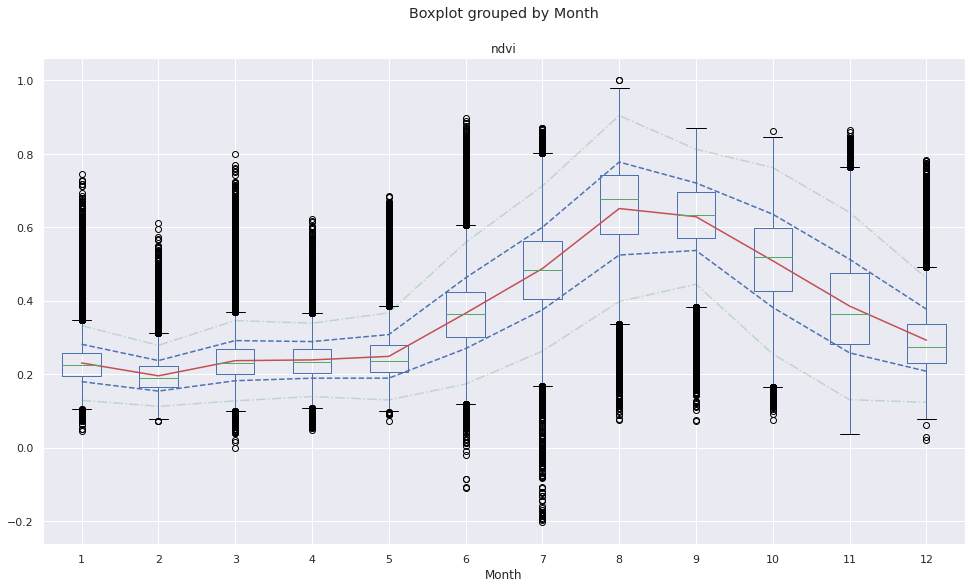

In [71]:
#Set figure size to a larger size
plt.rcParams["figure.figsize"] = [16,9]

#Create the boxplot
df.boxplot(by="Month",column="ndvi")

#Create the mean line
plt.plot(binned_data.index+1, binned_data.Mean, 'r-')

#Create the one standard deviation away lines
plt.plot(binned_data.index+1, binned_data.Mean-binned_data.Std_Dev, 'b--')
plt.plot(binned_data.index+1, binned_data.Mean+binned_data.Std_Dev, 'b--')

#Create the two standard deviations away lines
plt.plot(binned_data.index+1, binned_data.Mean-(2*binned_data.Std_Dev), 'g-.', alpha=.3)
plt.plot(binned_data.index+1, binned_data.Mean+(2*binned_data.Std_Dev), 'g-.', alpha=.3)

The plot above shows the distributions for each individual month over the baseline period.
<br>
- The <b><font color=red>red</font></b> line is the mean line which connects the <b><em>mean values</em></b> for each month.  
    <br>
- The dotted <b><font color=blue>blue</font></b> lines are exactly <b><em>one standard deviation away</em></b> from the mean and show where the NDVI values fall within 68% of the time, according to the Empirical Rule.  
    <br>
- The <b><font color=green>green</font></b> dotted lines are <b><em>two standard deviations away</em></b> from the mean and show where an estimated 95% of the NDVI values are contained for that month.
<br>


### Plot Z-Scores by Month and Year

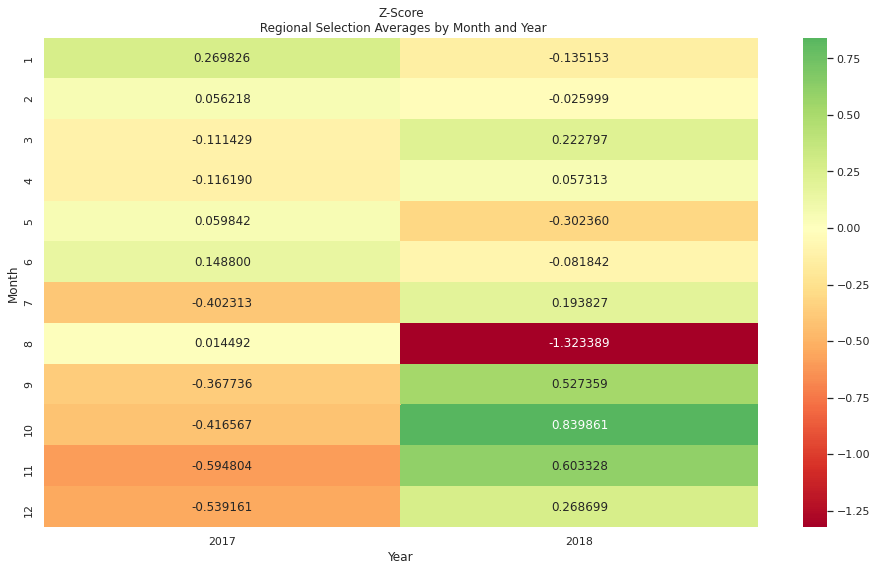

In [72]:

#Create heatmap layout from dataframe
img = pd.pivot_table(df, values="z_score",index=["Month"], columns=["Year"], fill_value=None)

#pass the layout to seaborn heatmap
ax = sns.heatmap(img, cmap="RdYlGn", annot=True, fmt="f", center = 0)

#set the title for Aesthetics
ax.set_title('Z-Score\n Regional Selection Averages by Month and Year')
ax.fill= None

In [73]:
from matplotlib.ticker import FuncFormatter

#Create a function for formatting our axes
def format_axis(axis, digits = None, suffix = ""):
    
    #Get Labels
    labels = axis.get_majorticklabels()
    
    #Exit if empty
    if len(labels) == 0: return
    
    #Create formatting function
    format_func = lambda x, pos: "{0}{1}".format(labels[pos]._text[:digits],suffix)
    
    #Use formatting function
    axis.set_major_formatter(FuncFormatter(format_func))
    

#Create a function for examining the z-score and NDVI of the region graphically
def examine(month = list(df["time"].dt.month.unique()), year = list(df["time"].dt.year.unique()), value_name = "z_score"):
    
    #This allows the user to pass single floats as values as well
    if type(month) is not list: month = [month]
    if type(year) is not list: year = [year]
          
    #pivoting the table to the appropriate layout
    piv = pd.pivot_table(df[df["time"].dt.year.isin(year) & df["time"].dt.month.isin(month)],
                         values=value_name,index=["latitude"], columns=["longitude"])
   
    #Sizing
    plt.rcParams["figure.figsize"] = [11,11]
    
    #Plot pivot table as heatmap using seaborn
    val_range = (-1.96,1.96) if value_name is "z_score" else (df[value_name].unique().min(),df[value_name].unique().max())
    ax = sns.heatmap(piv, square=False, cmap="RdYlGn",vmin=val_range[0],vmax=val_range[1], center=0)

    #Formatting        
    format_axis(ax.yaxis, 6)
    format_axis(ax.xaxis, 7) 
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90 )
    plt.gca().invert_yaxis()

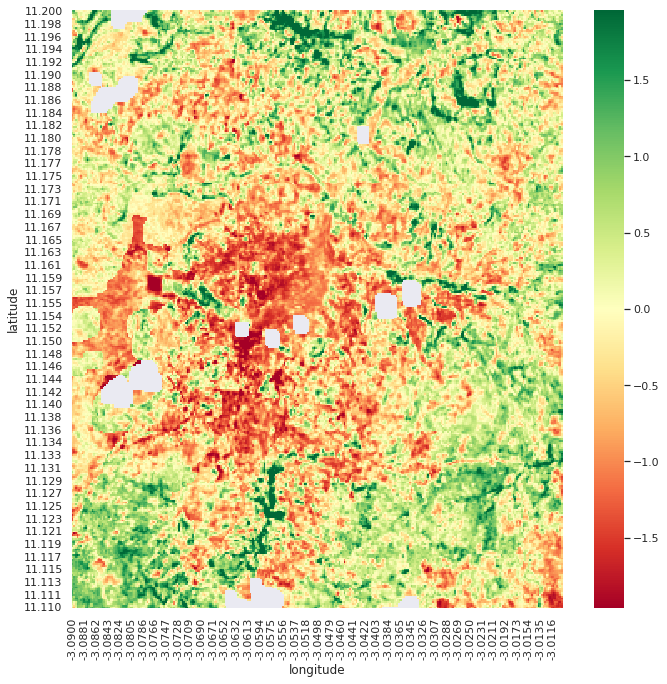

In [74]:

#This will generate a composite of the z-scores for the months and years selected
examine(month = [6], year = 2018, value_name="z_score")

In [75]:
import numpy as np
import matplotlib as mpl
import time

#Restrict input to a maximum of about 12 grids (months*year) for memory
def grid_examine(month = None, year = None, value_name = "z_score"):
    
    #default to all months then cast to list, if not already
    if month is None: month = list(df["Month"].unique())
    elif type(month) is int: month = [month]

    #default to all years then cast to list, if not already
    if year is None: year = list(df["Year"].unique())
    elif type(year) is int: year = [year]

    #get data within the bounds specified
    data = df[np.logical_and(df["Month"].isin(month) , df["Year"].isin(year))]
    
    #Set the val_range to be used as the vertical limit (vmin and vmax)
    val_range = (-1.96,1.96) if value_name is "z_score" else (df[value_name].unique().min(),df[value_name].unique().max())
    
    #create colorbar to export and use on grid
    Z = [[val_range[0],0],[0,val_range[1]]]
    CS3 = plt.contourf(Z, 200, cmap="RdYlGn")
    plt.clf()    
    
    
    #Define facet function to use for each tile in grid
    def heatmap_facet(*args, **kwargs):
        data = kwargs.pop('data')
        img = pd.pivot_table(data, values=value_name,index=["latitude"], columns=["longitude"], fill_value=None)
                
        ax = sns.heatmap(img, cmap="RdYlGn",vmin=val_range[0],vmax=val_range[1],
                         center = 0, square=True, cbar=False, mask = img.isnull())

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90 )
        plt.gca().invert_yaxis()
    
    
    #Create grid using the face function above
    with sns.plotting_context(font_scale=5.5):
        g = sns.FacetGrid(data, col="Year", row="Month", size=5,sharey=True, sharex=True) 
        mega_g = g.map_dataframe(heatmap_facet, "longitude", "latitude")      
        g.set_titles(col_template="Yr= {col_name}", fontweight='bold', fontsize=18)                         
       
        #Truncate axis tick labels using the format_axis function defined in block 13
        for ax in g.axes:
            format_axis(ax[0]._axes.yaxis, 6)
            format_axis(ax[0]._axes.xaxis, 7)
                
        #create a colorbox and apply the exported colorbar
        cbar_ax = g.fig.add_axes([1.015,0.09, 0.015, 0.90])
        cbar = plt.colorbar(cax=cbar_ax, mappable=CS3)
        plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 792x792 with 0 Axes>

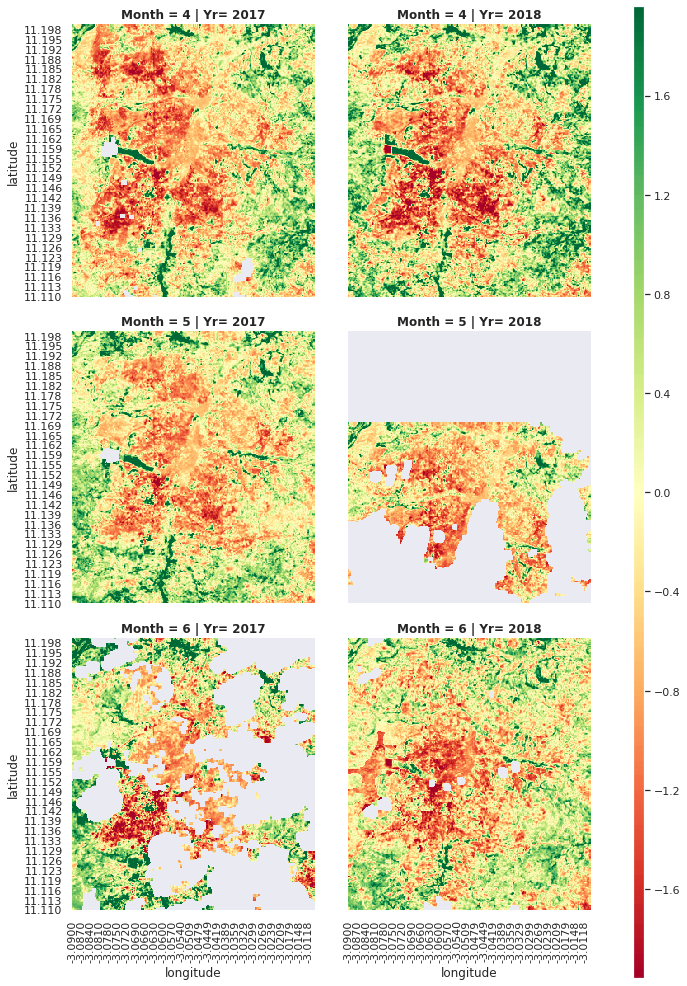

In [76]:
grid_examine(month=[4,5,6], year=[2017,2018])